### Installation de certains requirements

In [6]:
!pip3 install tqdm einops

In [7]:
!pip3 install torch

In [8]:
!pip3 install torchvision

In [9]:
!pip install timm

     |████████████████████████████████| 2.2 MB 3.2 MB/s eta 0:00:01     |███████████████████████████████▎| 2.2 MB 3.2 MB/s eta 0:00:01


### Importation des librairies

In [88]:
# Librairies utilisées
from tqdm.notebook import tqdm
import einops
import math
import numpy as np
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


from os import listdir
from os.path import isfile, join
import SimpleITK 
import skimage.io as io

from timm.models.layers import DropPath, to_2tuple, trunc_normal_

### Paramètres du modèle

In [89]:
# Parameters 
CT = "feature"                    # "input", "feature", or None
upscale = 2                     # Upscale factor (U) = 4
window_size = 16                # Window size (W)
embed_dim = 96                  # Embedding dimension (D) = 96
num_heads = [6] 
depths = [6]                        # Number of encoder layers (L) = 4
in_channels = (2 if CT=="input" else 1)                 # Number of channels for input images
input_size = 64  
shift_size = window_size // 2   #  Shift size (S)
num_features = 64      

# num_encoders = 12       # ViT-Base uses 12 encoder layers
# dropout = 0.1           # Dropout = 0.1 is used with ViT-Base & ImageNet-21k
# num_classes = 10        # Number of classes in CIFAR10 dataset
# size = 224              # Size used for training = 224

epochs = 100             # Number of epochs
base_lr = 1e-3         # Base LR
# weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)
batch_size = 64

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Device :", device)
print("Number of channel :", in_channels)
print("CT :", CT)

Device : cpu
Number of channel : 1
CT : feature


### Importation et préparation des données 

In [90]:
# Import data 
def load_data(repository_name, type_data) : 
    path = "../data/" + repository_name + "/"
    folders = [f for f in listdir(path) if not isfile(join(path, f))]
    X = []
    for folder in folders : 
        path_small = path + folder  + "/"
        files = [f for f in listdir(path_small) if (isfile(join(path_small, f)) & f.endswith(f"{type_data}.mhd"))]
        for file in files : 
            X.append(io.imread(path_small + file, plugin='simpleitk'))
    return X

In [91]:
type_data = ["low_edep", "high_edep", "ct"]
low_samp_data = load_data("MCsimulations", type_data[0])
high_samp_data = load_data("MCsimulations", type_data[1])
ct_data = load_data("MCsimulations", type_data[2])

In [92]:
# Transform data into tensors
low_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in low_samp_data]
high_samp_tensors = [torch.from_numpy(x).to(torch.float32) for x in high_samp_data]
ct_tensors = [torch.from_numpy(x).to(torch.float32) for x in ct_data]

In [93]:
import random

# List of patient indices from 1 to 82
index_patients = list(range(0, 82))

# Set the random seed for reproducibility
random.seed(1)

# Shuffle the list of patient indices
random.shuffle(index_patients)

# Assign indices to training, validation, and test sets
train_index = index_patients[:58]
val_index = index_patients[58:58+16]
test_index = index_patients[58+16:]

# Initialize lists to store training, validation, and test data
Low_train = []
High_train = []
CT_train = []

Low_val = []
High_val = []
CT_val = []

Low_test = []
High_test = []
CT_test = []

# Populate training data
for i in train_index:
    Low_train.extend(low_samp_tensors[i*80: (i+1)*80])
    High_train.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT is not None:
        CT_train.extend(ct_tensors[i*80: (i+1)*80])

# Populate validation data
for i in val_index:
    Low_val.extend(low_samp_tensors[i*80: (i+1)*80])
    High_val.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT is not None:
        CT_val.extend(ct_tensors[i*80: (i+1)*80])

# Populate test data
for i in test_index:
    Low_test.extend(low_samp_tensors[i*80: (i+1)*80])
    High_test.extend(high_samp_tensors[i*80: (i+1)*80])
    if CT is not None:
        CT_test.extend(ct_tensors[i*80: (i+1)*80])

print(f"The train data size is : {len(Low_train)}")
print(f"The validation data size is : {len(Low_val)}")
print(f"The test data size is : {len(Low_test)}")

The train data size is : 4640
The validation data size is : 1280
The test data size is : 640


### Configuration du modèle

In [94]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, act_layer=nn.GELU, out_features=None, drop=0.0):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.gelu = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [95]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows

In [96]:
def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x

In [97]:
# Class for W-MSA and SW-MSA
class WindowAttention(nn.Module):
    """"
    Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        input_channels (int): Number of input channels (C).
        window_size (tuple[int]): The height and width of the window (M).
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_dropout (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_dropout (float, optional): Dropout ratio of output. Default: 0.0
    """
    def __init__(self, input_channels, window_size, num_heads, qkv_bias=True, qk_scale = None,  attn_drop=0., proj_drop=0.):
        super().__init__()
        self.input_channels = input_channels
        self.window_size = window_size # (M, M) = (Window_Height, Window_Weight) = (Wh, Ww)
        self.num_heads = num_heads 
        head_dim = input_channels // num_heads
        self.scale = qk_scale or head_dim ** -0.5 

        # Parameter table of relative position bias 
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)) # matrix (torch) of zeros of shape((2*Wh-1)*(2*Ww-1), num_head)
        
        # Get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0]) # a tensor of int from 1 to Wh
        coords_w = torch.arange(self.window_size[1]) # a tensor of int from 1 to Ww
        coords = torch.stack(torch.meshgrid([coords_h, coords_w])) # a tensor of shape (2, Wh, Ww)
        coords_flatten = torch.flatten(coords, 1) # shape = (2, Wh*Ww)
        
        # Calculate relative position index for each token inside the window. We need:
        # coords_flatten[:,:,None] = (2, Ww*Wh, 1) and coords_flatten[:,None,:] = (2, 1, Ww*Wh)
        # None is just a way to add a dimension to the tensor at the position of the "None"
        # The substraction is an operation named "brodcasting" used to compute the pairwise differences beetween all pairs of coordinates in the grid
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :] # shape = (2, Ww*Wh, Ww*Wh)
        
        # This part makes us going from (2, M², M²) to (M², M², 2)
        # contiguous to ensure that the tensor is stored in a contiguous block of memory 
        relative_coords = relative_coords.permute(1, 2, 0).contiguous() # shape = (Ww*Wh, Ww*Wh, 2) 
        relative_coords[:, :, 0] += self.window_size[0] - 1 # shift to start from 0 along the x axis
        relative_coords[:, :, 1] += self.window_size[1] - 1 # shift to start from 0 along the y axis
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1 # scalling values wrt x-axis

        # This part makes us going from (M², M², 2) to (M², M²)
        # Sum of each matrix in the last dimension 
        # Buffers are parameters that are not updated during the training process. They are used to store data that is not needed for the training process. 
        #They are used to store data that is not needed for the training process.
        relative_position_index = relative_coords.sum(-1) # shape = (Ww*Wh, Ww*Wh) 
        self.register_buffer("relative_position_index", relative_position_index) # register the buffer to the module

        # Attention arguments 
        self.qkv = nn.Linear(input_channels, input_channels * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(input_channels, input_channels)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02) # initialization of the relative_position_bias_table
        self.softmax = nn.Softmax(dim=-1) # softmax function


    def forward(self, x, mask = None):
        """"
        Args : 
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        '''
        3: referring to q, k, v (total 3)
        B: batch size
        num_heads: multi-headed attention
        N:  M^2, referring to each token(patch)
        C // num_heads: Each head of each of (q,k,v) handles C // num_heads -> match exact dimension for multi-headed attention
        '''
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4) # shape = (3, B_, num_head, N, C/num_head)
        q, k, v = qkv[0], qkv[1], qkv[2] # shape = (B_, num_head, N, C/num_head)

        q = q * self.scale # scale the query vector by the scale factor
        # attention becomes (B_, num_heads, N, N) shape where N = M^2
        attn = (q @ k.transpose(-2, -1)) # shape = (B_, num_head, N, N)

        # Remember that relative_position_bias_table = ((2M-1)*(2M-1), num_heads), B_hat from the paper
        # relative_position_index's elements are in range [0, 2M-2]
        # Convert to (M^2, M^2, num_heads). This is B matrix from the paper
        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1],  -1
        )
        # Convert to (num_heads, M^2, M^2) to match the dimension for addition
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        
        # (B, num_heads, N, N) + (1, num_heads, M^2, M^2), where N=M^2
        # attn becomes (B_, num_heads, N, N) or (B, num_heads, M^2, M^2)
        attn = attn + relative_position_bias.unsqueeze(0) # also a broadcasting operation


###############################################################################
        if mask is not None:
            nW = mask.shape[0] # nW = number of windows
            
            # attn.view(...) = (B, nW, num_heads, N, N)
            # mask.unsqueeze(1).unsqueeze(0) = (1, num_windows, 1, M^2, M^2)
            # So masking is broadcasted along B and num_heads axis which makes sense
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            
            # attn = (nW * B, num_heads, N, N)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)
            
        attn = self.attn_drop(attn)
        
        # attn = (nW*B, num_heads, N, N)
        # v = (B_, num_heads, N, C // num_heads). B_ = nW*B
        # attn @ v = (nW*B, num_heads, N, C // num_heads)
        # (attn @ v).transpose(1, 2) = (nW*B, N, num_heads, C // num_heads)
        # Finally, x = (nW*B, N, C), reshape(B_, N, C) performs concatenation of multi-headed attentions
        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        
        # Projection Matrix (W_0). dim doesn't change since we used C // num_heads for MSA
        # x = (B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x        

In [98]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA (choosen as the half of the window size).
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        """
            x : input image
            x_size : tuple corresponding to the number of patches for an image
        """
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C) # Corresponds to an unflatten in the second dimension

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # num_Windows*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # num_Windows*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops

In [99]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [100]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

In [101]:
# Create a class for patchification and embedding
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim, norm_layer = False):
        super().__init__()
        self.img_size = to_2tuple(img_size)
        self.patch_size = to_2tuple(patch_size)
        self.patches_resolution = [self.img_size[0] // self.patch_size[0], self.img_size[1] // self.patch_size[1]]
        self.num_patches = self.patches_resolution[0] * self.patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        # Add norm if norm_layer is not None
        self.norm = norm_layer(self.embed_dim) if norm_layer else None
        

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2) # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

In [102]:
class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

In [103]:
class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)

In [104]:
class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

In [105]:
class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        y = self.residual_group(x, x_size)
        y = self.patch_unembed(y, x_size)
        y = self.conv(y)
        y = self.patch_embed(y) + x
        return y

In [106]:
class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        self.embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
        ct: usage of the ct data. 'input'/'feature'/None (default)
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv', ct=None,
                 **kwargs):
        super(SwinIR, self).__init__()
        self.num_in_ch = in_chans
        self.num_out_ch = 1 # in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size
        
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = self.embed_dim
        self.mlp_ratio = mlp_ratio

        self.ct = ct
        

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(self.num_in_ch, self.embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=self.embed_dim, embed_dim=self.embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=self.embed_dim, embed_dim=self.embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, self.embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=self.embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            if self.ct == 'feature':
                self.embed_dim += 1
                self.conv_after_body = nn.Conv2d(self.embed_dim, self.embed_dim, 3, 1, 1)
            else:
                self.conv_after_body = nn.Conv2d(self.embed_dim, self.embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(self.embed_dim, self.embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(self.embed_dim // 4, self.embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(self.embed_dim // 4, self.embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(self.embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, self.num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, self.embed_dim, self.num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(self.embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, self.num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            if self.ct == 'feature':
                self.conv_last = nn.Conv2d(self.embed_dim+1, self.num_out_ch, 3, 1, 1)
            else:
                self.conv_last = nn.Conv2d(self.embed_dim, self.num_out_ch, 3, 1, 1)
            

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        if self.ct=="feature" :
            y = torch.unbind(x, 1)[1]
            x = torch.unbind(x, 1)[0]
            y = y.unsqueeze(1)

        # print(x.shape)
        if self.num_in_ch == 1:
            x = x.unsqueeze(1)
        
        # print(x.shape)
        H, W = x.shape[2:]
        x = self.check_image_size(x)
        
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            print(x.shape)
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            print(x.shape)
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            x_first = self.forward_features(x_first)
            if self.ct == 'feature':
                x_first = torch.cat((x_first, y), 1)

            res = self.conv_after_body(x_first) + x_first
            if self.ct == 'feature':
                res = torch.cat((res, y), 1)

            if self.ct == 'input':
                x = torch.unbind(x, 1)[0]
                x = x.unsqueeze(1)

            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        y = x[:, :, :H*self.upscale, :W*self.upscale]
        y = y.squeeze(1)
        return y

### Préparation des données

In [107]:
# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, low, high, ct=None):
        self.low = low
        self.high = high
        self.ct = ct

    def __len__(self):
        return len(self.low)

    def __getitem__(self, idx):
        X = self.low[idx]
        y = self.high[idx]
        
        if self.ct is not None:
            X = torch.stack([self.low[idx], self.ct[idx]], dim=0)
        
        return X, y
    
# DataLoader
if CT:
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train, CT_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val, CT_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test, CT_test),
                                batch_size=batch_size, shuffle=True)
else :
    dataloader_train = DataLoader(dataset=CustomDataset(Low_train, High_train), 
                                batch_size=batch_size, shuffle=True)
    dataloader_val = DataLoader(dataset=CustomDataset(Low_val, High_val), 
                                batch_size=batch_size, shuffle=True)
    dataloader_test = DataLoader(dataset=CustomDataset(Low_test, High_test),
                                batch_size=batch_size, shuffle=True)

In [108]:
for X, y in dataloader_test:
    print(X[3])
    print(X.shape)
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([64, 2, 64, 64])


In [109]:
# Train and Test loop
def train_loop(dataloader, model, loss_fn, optimizer, device):

    model.train()

    for X, y in dataloader:
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward
        pred = model(X)
        #print(pred.shape, y.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()


def eval_loop(dataloader, model, loss_fn, device):

    model.eval()
    size = len(dataloader.dataset)
    #num_batches = len(dataloader)
    loss = 0.

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()

    #loss /= num_batches
    return loss

### Initialisation du modèle

In [110]:
height = width = 64
SwinIR_model = SwinIR(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1., depths=depths, in_chans=in_channels, # le nombre de channels dépend directement du ct
                embed_dim=60, num_heads=num_heads, mlp_ratio=2, upsampler='', ct=CT)
print(SwinIR_model)

loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(SwinIR_model.parameters(), lr=base_lr)
save_path = './Saved_models/model_SwinIR_with_CT_asfeature_batch64_epo100.pth'

SwinIR(
  (conv_first): Conv2d(1, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=60, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=60, input_resolution=(64, 64), num_heads=6, window_size=16, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((60,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=60, out_features=180, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=60, out_features=60, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (d

In [111]:
import os
from tempfile import TemporaryDirectory

def train_model(dataloaders,
                model,
                criterion,
                optimizer,
                device,
                n_epochs, 
                save_path):
    loss_train_list = []
    loss_val_list = []
    
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_loss = 1e2

        for t in range(n_epochs):
            print(f"Epoch {t + 1}\n-------------------------------------------------")

            # Train loop
            train_loop(dataloaders["train"], model, criterion, optimizer, device)
            print('Training done !!! \n Evaluation ')

            # Evaluation loop
            loss_train = eval_loop(dataloaders["train"], model, criterion, device)
            loss_train_list.append(loss_train)
            print(f"Training set:  Avg loss: {loss_train: >8f}")

            loss_val = eval_loop(dataloaders["val"], model, criterion, device)
            loss_val_list.append(loss_val)
            print(f"Validation set:   Avg loss: {loss_val: >8f}\n")
            if loss_val < best_loss : 
                best_loss = loss_val
                torch.save(model.state_dict(), best_model_params_path)
        
        model.load_state_dict(torch.load(best_model_params_path))
        torch.save(model.state_dict(), save_path)

        print("Done!")

    return model, loss_train_list, loss_val_list

### Running the model

In [112]:
import time
start = time.time()
swinir_model, loss_train, loss_val = train_model(
                                model=SwinIR_model,
                                criterion=loss_fn,
                                optimizer=optimizer,
                                dataloaders={'train': dataloader_train, 'val': dataloader_val},
                                device=device,
                                n_epochs=epochs,
                                save_path=save_path)


end = time.time() - start

Epoch 1
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 1.113190
Validation set:   Avg loss: 0.304994

Epoch 2
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.822070
Validation set:   Avg loss: 0.225371

Epoch 3
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.730439
Validation set:   Avg loss: 0.200014

Epoch 4
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.513233
Validation set:   Avg loss: 0.140547

Epoch 5
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.522814
Validation set:   Avg loss: 0.143114

Epoch 6
-------------------------------------------------
Training done !!! 
 Evaluation 
Training set:  Avg loss: 0.531407
Validation set:   Avg loss: 0.145797

Epoch 7
--------------------

In [114]:
print(end)

51735.65305042267


In [115]:
print(f'Temps mis :  {end}, soit {time.strftime("%H:%M:%S", time.gmtime(end))}')

Temps mis :  51735.65305042267, soit 14:22:15


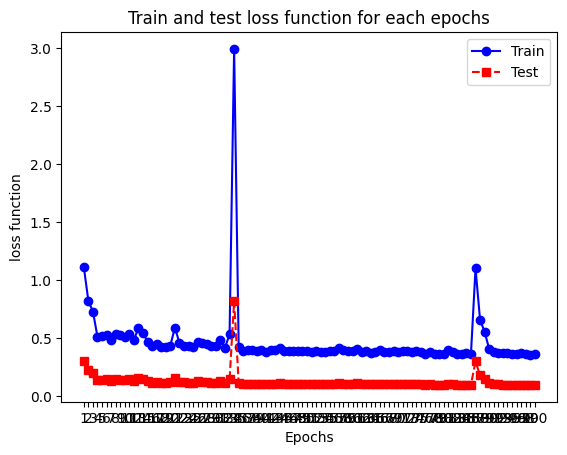

In [116]:
import matplotlib.pyplot as plt

def plot_result(x, y, n_epochs, labelY):
    range_epochs = range(1, n_epochs+1)

    # Plotting the train loss evolution
    plt.plot(range_epochs, x, marker='o', linestyle='-', color='b', label='Train')

    # Plotting the test loss evolution
    plt.plot(range_epochs, y, marker='s', linestyle='--', color='r', label='Test')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel(labelY)
    plt.title(f'Train and test {labelY} for each epochs')

    # Adding a legend to the plot
    plt.legend()

    # Set x-axis ticks to all possible values of x
    plt.xticks(range_epochs)

    # Display the plot
    plt.show()

plot_result(x=loss_train, y=loss_val, n_epochs=epochs, labelY="loss function")

In [117]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap


import SimpleITK 
import skimage.io as io



def affiche_images(low_image, pred_image, high_image):
    ##### Une mode de CMP############
    top = cm.get_cmap('viridis', 64)
    bottom = cm.get_cmap('plasma', 960)
    newcolors = np.vstack((top(np.linspace(0, 1, 64)),
                        bottom(np.linspace(1, 0, 960))))
    newcmp = ListedColormap(newcolors, name='MonteCarlo')

    fig1 = plt.figure(constrained_layout=True, figsize=(9, 3))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig1)
    ######
    ax1 = fig1.add_subplot(spec[0])
    plt.imshow(low_image, interpolation=None, cmap=newcmp)
    plt.ylabel('Une coupe de bassin',fontweight='bold')
    plt.xlabel('Low Sampling',fontweight='bold')
    plt.xticks([], [])
    plt.yticks([], [])

    ax1b = fig1.add_subplot(spec[1])
    plt.imshow(torch.detach(pred_image), interpolation=None, cmap=newcmp)
    plt.xlabel('Pred Sampling',fontweight='bold')
    plt.xticks([], [])
    plt.yticks([], [])

    ax2 = fig1.add_subplot(spec[2])
    plt.imshow(high_image, interpolation=None, cmap=newcmp)
    plt.xlabel('High Sampling',fontweight='bold')
    # plt.colorbar(aspect=50)
    plt.xticks([], [])
    plt.yticks([], [])
    ###########
    plt.show()

/tmp/ipykernel_26311/4167923843.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_26311/4167923843.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)


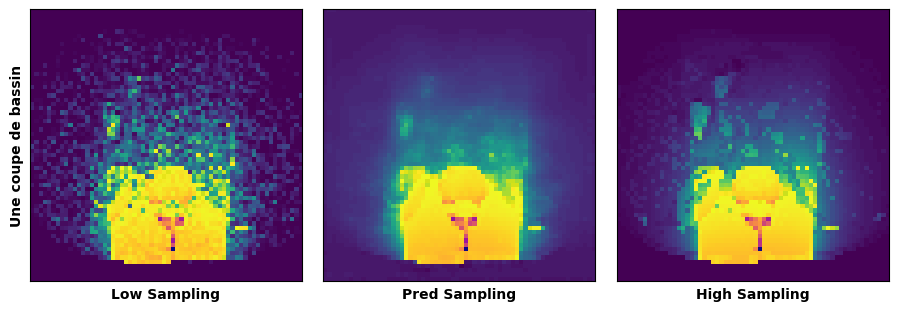

In [118]:
def function_for_load(model_path, dataloader, ind):
    model = SwinIR(upscale=1, img_size=(height, width),
                window_size=window_size, img_range=1., depths=depths, in_chans=in_channels, # le nombre de channels dépend directement du ct
                embed_dim=60, num_heads=num_heads, mlp_ratio=2, upsampler='', ct=CT)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    for X, y in dataloader:
        with torch.no_grad():
            result = model(X)
        data = X
        label = y
        break
    result = torch.squeeze(result, dim=1)
    low_im = data[ind, :, :][0]
    pred_im = result[ind, :, :]
    high_im = label[ind, :, :]
    affiche_images(low_image=low_im, pred_image=pred_im, high_image=high_im)

function_for_load(model_path=save_path, dataloader=dataloader_test, ind=2)

/tmp/ipykernel_26311/4167923843.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('viridis', 64)
/tmp/ipykernel_26311/4167923843.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('plasma', 960)


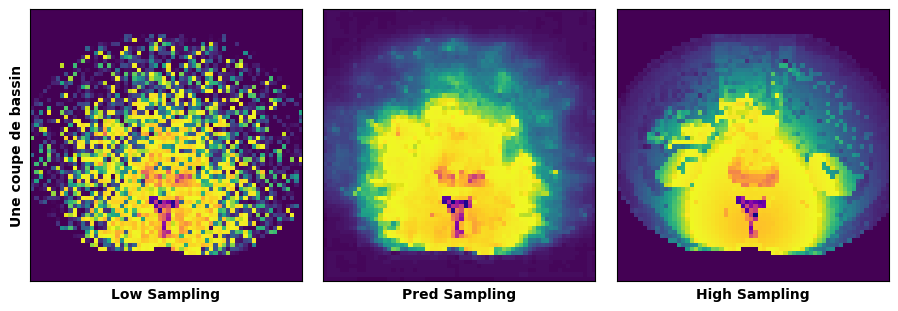

In [136]:
function_for_load(model_path=save_path, dataloader=dataloader_test, ind=1)

In [35]:
save_path

'./Saved_models/model_SwinIR_with_CT_asfeature.pth'

In [37]:
print(time.strftime("%H:%M:%s", time.gmtime(end)))

04:09:11393
